# Final Project Baseline
**Project:** Facial Keypoints Detection

**Authors:** Richard Ryu, Nick Cirella, Diana Iftimie

**Team:** RnD

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## I. Introduction & Purpose

The purpose of this project is to develop a working model for solving the core Facial Keypoints Detection problem. At a high level, Facial Keypoints Detection is a task where given a image of a human face, a model analyzes the image and detects facial keypoints for the identified face. Such facial keypoints include the centers and corners of the eyes, the corners of the mouth, and the tip of the nose, among other facial key points. To accomplish this task, the model must predict coordinates (x, y) in the pixel space of the given image of a face.

As a computer vision problem, the Facial Keypoints Detection task has a wide variety of applications. From the basic task of identifying facial keypoints of a given image of a face, these results can be used to solve the task of identifying faces in images (a.k.a. facial recognition). These results then enable solving much more complex problems, including tracking (multiple) faces in videos (such as in security camera footage) and analyzing facial expressions in different faces (emotion understanding, which can be used in sentiment analysis based on camera footage). This technology can even extend to doing more complex biometrics analysis, which is heavily used to identify people simply using an image of their face, such as Microsoft's Face API & Windows Hello and Apple's Face ID for iPhones. Thus, accomplishing the facial keypoints detection task is central to much of the work done in this day and age on basic human understanding in computer vision. 

For the purpose of this project, we will focus on the Facial Keypoints Detection task as defined in the Kaggle Challenge linked here: https://www.kaggle.com/c/facial-keypoints-detection/overview/description

## II. High-Level Machine Learning Task

As mentioned above, the goal of this machine learning task is to accurately predict a set of facial keypoints as coordinates in pixel space, given an image of a face (the inference task). That is, we aim to develop a model (or multiple iterations of a model) that is able to learn generalized information about the facial keypoints detection task from a training set available on the kaggle challenge for Facial Keypoints Detection. For training, our input is a set of images of faces and our output is a set of facial keypoints that correspond to each image. We will train a model that is able to generally capture the relationship between input and output data in order to accomplish the inference task of detecting keypoints given new images of faces. 

## III. The Data (High-Level)

As described previously, our input data consists of images, both for training and test. We will refer to both of these datasets in the context of the Kaggle competition, as "Kaggle Competition Training" and "Kaggle Competition Test", as they are specifically related to the Kaggle Competition task. This will avoid confusing with the subsets of Kaggle Competition Training data that we will use for actual model training, hyperparameter tuning, and evaluation. 

### Kaggle Competition Training Data

In [2]:
# Load and display training data
kaggle_competition_training_data = pd.read_csv('data/training/training.csv')
print("Kaggle Competition Training Data Shape: ", kaggle_competition_training_data.shape)
kaggle_competition_training_data.head(1)

Kaggle Competition Training Data Shape:  (7049, 31)


,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...


In [15]:
# Checking for null values in our dataset
isnulls = kaggle_competition_training_data.isnull()
isnulls_sum = isnulls.sum()
print("Number of Null Values for Each Feature\n\n",isnulls_sum)

Number of Null Values for Each Feature

 left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_c

For the Kaggle Competition Training data that is available for constructing our model, we have a total of `7049` images to consider when training our model(s). Each of thse images are `96x96` pixels in dimension, with the pixel values organized as lists of row-ordered pixel values ranging between `(0, 255)` (for a total of `9216` values) which lives in the `Image` column of the table (the right-most column). The structure of the pixel values is very similar to that seen in the MNIST dataset in Project 1. 

Unfortunately, our training dataset contains vast amount of null values for various features. To summarize, features starting from 'left_eye_inner_corner_x' to 'right_eyebrow_outer_end_y' has about 4780 null values and close to all of mouth features also had about 4780 null values. Fortunately, there were no null values for the images and nose features. 

In addition to the `Image` column with the actual image data, we see the first 30 columns correspond to 15 facial keypoints (each pair of columns correspond to the `x` and `y` pixel coordinates of one facial keypoint). For example, the first column indicates `left_eye_center_x` and the second column indicates `left_eye_center_y`, which in combination correspond to coodinates (`x`, `y`) of the facial keypoint for the center of the left eye.

With this data, we have both the input (images) and the correct output (facial keypoints labels) that can be used to train our model(s). In order to properly evaluate our model and keep it from overfitting, we will split this data into train, dev, and test sets.

We can see some examples of images and their corresponding facial keypoints shown below:
$\color{orange}{\text{In Progress: add example images below!}}$

In [24]:
# TODO: add example images on left-hand side and overlay with facial keypoints
# WARNING: This takes quite some time to run

# Loop to re-store all image values in comma separated list object
training_image_list = []
for i in range(len(kaggle_competition_training_data["Image"])):
    training_image_list.append(kaggle_competition_training_data["Image"][i].split(" "))

# reshaping the image list object into array
training_image_array = np.array(training_image_list, dtype = 'float')
len(training_image_array)

7049

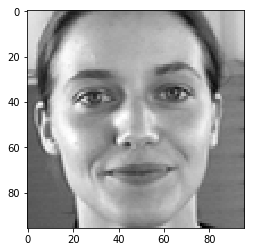

In [23]:
# plotting some example images into 96x96 after reshaping them 'hardcoded to 10th image'
plt.imshow(training_image_array[9].reshape(96,96), cmap='gray')

#### Dealing with Missing Facial Keypoints

Upon closer inspection of the Kaggle Competition Training Data, there are some samples in the dataset that do not have all 15 facial keypoints recorded--some of them are missing. As a result, this will affects how we end up doing model evaluation (namely, we do not know what the groud-truth labels are for those keypoints that are missing, even though the model will predict those keypoints). 

Because of these missing labels, it would be best to ensure that the model can still be properly trained and evaluated, even in the absence of these labels (e.g. don't adjust model based on predictions for keypoints that are missing, just ignore those predictions for those particular examples; it would be best to also have a broader discussion with Professor Yacov about strategies on how we might do adjusted evaluation to deal with these missing labels).

### Kaggle Competition Test Data

In [10]:
kaggle_competition_test_data = pd.read_csv('data/test/test.csv')
print("Kaggle Competition Test Data Shape: ", kaggle_competition_test_data.shape)
kaggle_competition_test_data.head(1)

Kaggle Competition Test Data Shape:  (1783, 2)


,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...


Furthermore, we have the Kaggle Competition Test data provided to use, which is used for the final evaluation stage in the competition. In this dataset, we have a total of `1783` images that are also `96x96` pixels in dimension, the pixel values organized as lists of row-ordered pixel values ranging between `(0, 255)` that live in the `Image` column of the tabe (the right-most column. 

Unlike the Kaggle Competition Training data, we do not have facial keypoints as lables, and instead, we only have and `ImageId` associated with each image. This is because for the actual Kaggle Competition Submission, we will need to use our model constructed from the Kaggle Competition Training data and predict facial keypoints for each of the entries in the Kaggle Competition Test dataset. Thus, only Kaggle has the "correct labels", and we will not be able to do any evaluation on this dataset; this datset will be used for submission only.

## IV. Feature Engineering

Because our input data for this task consists of images, we will focus our feature engineering to leveral image processing techniques, such as those seen in Project 1 for the MNIST dataset.

Starting from the arrays of raw pixel values that describe each image, we will investigate some of the following techniques for feature engineering and pre-processing these images:
 * Normalizing pixel values (have them range between (0.0, 1.0))
 * Gaussian Blur (or other blurring techniques)
 * Binning pixel values (e.g. [0, 99] -> 0, [100, 199] -> 1, [200, 255] -> 2)
 * Adding Gaussian Noise (or other type of noise)
 * Singular Value Decomposition / Principal Component Analysis (and use top n principal components to describe images)

We go into more details of each of the possible techniques below.

### Normalizing Pixel Values
$\color{red}{\text{TODO: discuss normalization techniques described, and explain how used in project 1 at start}}$
 
### Blurring Images
$\color{red}{\text{TODO: discuss blurring techniques described, and explain how used in project 1 in P6}}$

### Binning Pixel Values
$\color{red}{\text{TODO: discuss binning techniques described, and explain how used in project 1 in P9}}$
 
### Adding Noise of Images 
$\color{red}{\text{TODO: discuss adding noise techniques described, and explain how used in project 1 in P9}}$

### SVD / PCA
$\color{red}{\text{TODO: discuss how can use SVD/PCA, similar to music genre classification assignment Diana worked on once}}$

## V. Modeling Techinques & Training

$\color{red}{\text{TODO: add modeling discussion}}$

### Keras as framework for Neural Networks

### Convolutional Neural Networks

### Different convolutional filters (kernels, widths, etc.)

### Different settings for CNN (# of layers, learning rate, # of neurons, etc.)

### Doing evaluation against another model (e.g. SVM?)

## IV. Evaluation of Approaches

Precision, Recall, Precision-recall curves, accuracy over time curves

On Kaggle, our submission will be scored on the root mean squared error:

$\textrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$
